# Summmary of the ongoing work in CESM/MOM6

Gustavo Marques (gmarques@ucar.edu)

12/18/2018

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Purpose of this presentation

Bring the ocean section up-to-date with the developent going on in CESM/MOM6, present and discuss results obtained thus far and get feedback from participants. 

## Topics to be discussed

1) Status of forced (JRA-55) ocean/sea-ice experiments

2) Status of fully-coupled experiments (won't show resuts today)

3) Ongoing development and testing of new parameterizations

## Forced ocean/sea-ice experiments 

### Brief description of the baseline experiment (hereafter EXP#2)

**<font color=blue>Numerics</font>**

* Boussinesq ($\rho_0 = 1035$ kg m$^3$) and hydrostatic 
* Nominal 2/3$^o$ horizontal grid spacing, with equatorial refinement
* Vertical coordinate is z*, with 63 model layers (reconstruction scheme is 3rd-order accurate)
* Barotropic time step is automatically set based on the maximum stable value
* Baroclinc time step = 1200 s
* Tracer time step = coupling time step = 3600 s
* Equation of state from Wright (1997)

**<font color=blue>Parameterizations</font>**

* Vertical mixing via CVMix, parameters set to same values used in POP
    * Constant background diapycnal diffusivity = 2.0E-5 m$^2$ s$^{-1}$
    * KPP
    * Internal tides (Simmons)
    * Convection
    * Double-diffusion
    * Interior (LMD94)
    * Using the latitude-dependent scaling for the near surface background diffusivity, as described in Harrison & Hallberg, JPO 2008 (**should have been off by default**)
    * Missing the latitude-dependent background diffusivity described in Danabasoglu et al., 2012 (**should have been on by default**)

* Constant GM  = 800 m$^2$ s$^{-1}$
    * Scaled when depth is shallower than 1 km
    * Using the streamfunction formulation of Ferrari et al., 2010
* Constant background along-isopycnal tracer diffusivity = 800 m$^2$ s$^{-1}$
    * Using the continuous neutral diffusion scheme
* Mixed layer re-stratification by sub-mesoscale eddies (Fox-Kemper et al., 2010)
    * MLE_FRONT_LENGTH = 1 km
    * MLE_MLD_DECAY_TIME = 4 days
* Constant Laplacian horizontal viscosity = 1000 m$^2$ s$^{-1}$
* Biharmonic horizontal viscosity using a velocity scale = 0.1 m s$^{-1}$
* Quadratic bottom drag, with CDRAG = 0.003
* SW penetration using a single exponent decay

**<font color=blue>Initial Conditions</font>**

* Potential temperature and salinity from WOA05
* U = V = 0

**<font color=blue>Forcing</font>**

* JRA-55 (v1.3)
* SSS restoring (WOA05) piston velocity = 0.1667 m/day (~ 60 m/year)
```
ADJUST_NET_SRESTORE_TO_ZERO = True !   [Boolean] default = True
                                ! If true, adjusts the salinity restoring seen to zero whether restoring is via
                                ! a salt flux or virtual precip.
ADJUST_NET_FRESH_WATER_TO_ZERO = True !   [Boolean] default = False
                                ! If true, adjusts the net fresh-water forcing seen by the ocean (including
                                ! restoring) to zero.
```

### Additional experiments

* EXP#4: SSS restoring piston velocity = 0.274 m/day (~ 100 m/year)
* EXP#5: SSS restoring piston velocity = 0.5556 m/day (~ 200 m/year)
* EXP#6: SSS restoring piston velocity = 0.274 m/day (~ 100 m/year) + Laplacian viscosity = 500 m$^2$ s$^{-1}$
* CORE: CORE IAF forcing + baseline configuration
* EXP#8: MEKE, 0.1667 m/day
* EXP#9: MEKE, 0.274 m/day
* EXP#10: MEKE, 0.1667 m/day, GME

### 1.1 Globally-averaged ocean properties

In [4]:
path = '/glade/scratch/gmarques/'
exps = ['g.c2b6.GJRA.TL319_t061.long_JRA_mct.002', \
        'g.c2b6.GJRA.TL319_t061.long_JRA_mct.004',  \
        'g.c2b6.GJRA.TL319_t061.long_JRA_mct.005',  \
        'g.c2b6.GJRA.TL319_t061.long_JRA_mct.006', \
        'g.c2b6.GIAF.T62_t061.long_run.001',\
        'g.c2b6.GJRA.TL319_t061.long_JRA_mct.007',\
        'g.c2b6.GJRA.TL319_t061.long_JRA_mct.008',\
        'g.c2b6.GJRA.TL319_t061.long_JRA_mct.009']
labels = ['EXP2', 'EXP4', 'EXP5', 'EXP6', 'CORE', 'EXP7', 'EXP8', 'EXP9']

def get_data(full_path, variables):
  def preprocess(ds):
    ''' Return the dataset with variable'''
    return ds[variables]
  ds = xr.open_mfdataset(full_path, data_vars='minimal', \
                         coords='minimal', compat='override', preprocess=preprocess)
  return ds

import seaborn, matplotlib
matplotlib.rcParams.update({'font.size': 14})
variables = ['thetaoga', 'soga']

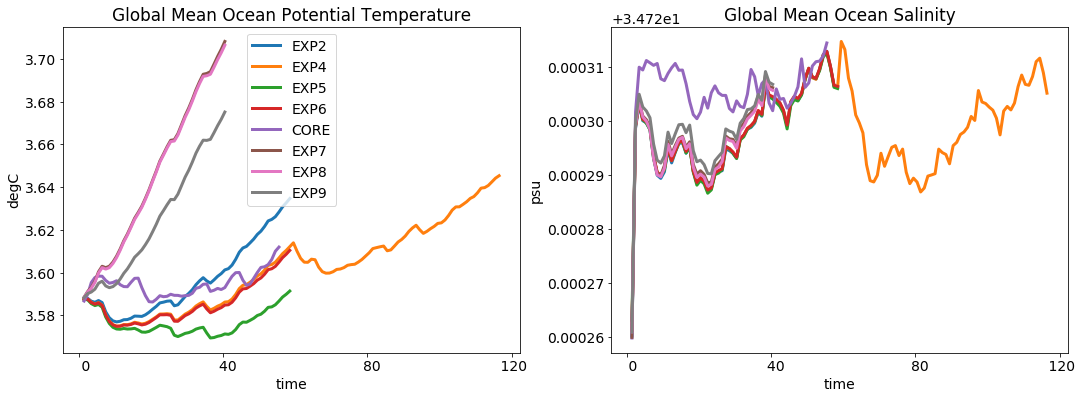

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
for i in range(len(exps)):
  ds = get_data(path+exps[i]+'/run/*mom6.hm_*.nc',variables)
  ds['thetaoga'].plot(ax=ax[0], label=labels[i], lw=3)
  ds['soga'].plot(ax=ax[1], lw=3)

ax[0].set_title(ds.thetaoga.attrs['long_name']); ax[0].set_ylabel(ds.thetaoga.attrs['units'])
ax[1].set_title(ds.soga.attrs['long_name']); ax[1].set_ylabel(ds.soga.attrs['units']); ax[0].legend()

### 1.2 Mixed layer depth (March Mean)

<table>
<tr><td><img src='g.c2b6.GJRA.TL319_t061.long_JRA_mct.002_MLD_model_March.png'></td>
<td><img src='g.c2b6.GJRA.TL319_t061.long_JRA_mct.004_MLD_model_March.png'></td></tr>
<tr><td><img src='g.c2b6.GJRA.TL319_t061.long_JRA_mct.005_MLD_model_March.png'></td>
<td><img src='g.c2b6.GJRA.TL319_t061.long_JRA_mct.006_MLD_model_March.png'></td></tr> 
 <tr><td><img src='g.c2b6.GIAF.T62_t061.long_run.001_MLD_model_March.png'></td></tr>
</table>

<center> <font size="4">Mixed layer depth time series</font>

Text(0.5, 1.0, 'Averaged MLD in the Lab Sea')

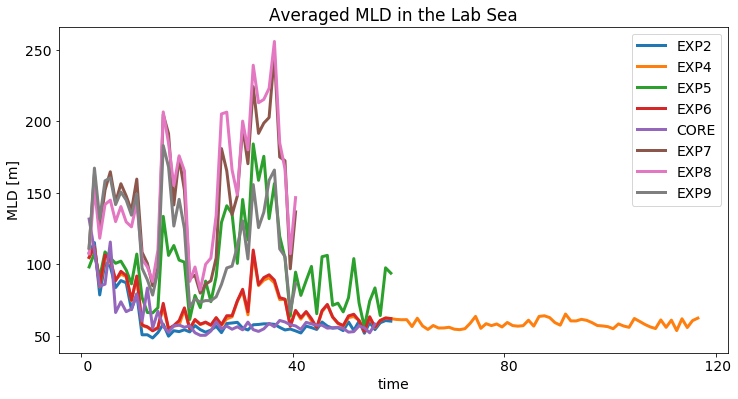

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_mlotst_stats.nc')
  ds.sel(basin='LabSea').sel(stats='da_mean').__xarray_dataarray_variable__.plot(ax=ax, \
        lw=3, label=labels[i])
  #ds.__xarray_dataarray_variable__.plot(ax=ax, label=labels[i])

ax.set_ylabel('MLD [m]'); ax.legend(); ax.set_title('Averaged MLD in the Lab Sea')

Text(0.5, 1.0, 'Maximum MLD in the Lab Sea')

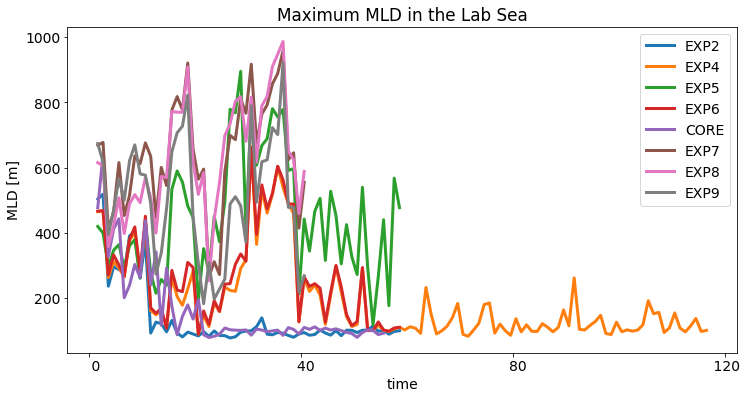

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_mlotst_stats.nc')
  ds.sel(basin='LabSea').sel(stats='da_max').__xarray_dataarray_variable__.plot(ax=ax, label=labels[i], lw=3)
  #ds.__xarray_dataarray_variable__.plot(ax=ax, label=labels[i])

ax.set_ylabel('MLD [m]'); ax.legend(); ax.set_title('Maximum MLD in the Lab Sea')

###  1.3 Poleward Heat Transport

In [6]:
def get_heat_transport_obs():
  import netCDF4
  """Plots model vs obs poleward heat transport for the global, Pacific and Atlantic basins"""
  # Load Observations
  fObs = netCDF4.Dataset('/glade/work/gmarques/cesm/datasets/Trenberth_and_Caron_Heat_Transport.nc')
  #Trenberth and Caron
  yobs = fObs.variables['ylat'][:]
  NCEP = {}; NCEP['Global'] = fObs.variables['OTn']
  NCEP['Atlantic'] = fObs.variables['ATLn'][:]; NCEP['IndoPac'] = fObs.variables['INDPACn'][:]
  ECMWF = {}; ECMWF['Global'] = fObs.variables['OTe'][:]
  ECMWF['Atlantic'] = fObs.variables['ATLe'][:]; ECMWF['IndoPac'] = fObs.variables['INDPACe'][:]

  #G and W
  Global = {}
  Global['lat'] = np.array([-30., -19., 24., 47.])
  Global['trans'] = np.array([-0.6, -0.8, 1.8, 0.6])
  Global['err'] = np.array([0.3, 0.6, 0.3, 0.1])

  Atlantic = {}
  Atlantic['lat'] = np.array([-45., -30., -19., -11., -4.5, 7.5, 24., 47.])
  Atlantic['trans'] = np.array([0.66, 0.35, 0.77, 0.9, 1., 1.26, 1.27, 0.6])
  Atlantic['err'] = np.array([0.12, 0.15, 0.2, 0.4, 0.55, 0.31, 0.15, 0.09])

  IndoPac = {}
  IndoPac['lat'] = np.array([-30., -18., 24., 47.])
  IndoPac['trans'] = np.array([-0.9, -1.6, 0.52, 0.])
  IndoPac['err'] = np.array([0.3, 0.6, 0.2, 0.05,])

  GandW = {}
  GandW['Global'] = Global
  GandW['Atlantic'] = Atlantic
  GandW['IndoPac'] = IndoPac
  return NCEP, ECMWF, GandW, yobs

NCEP, ECMWF, GandW, yobs = get_heat_transport_obs()
from mom6_tools.poleward_heat_transport import annotateObs, plotGandW, plotHeatTrans, heatTrans

Basemap module not found. Some regional plots may not function properly


In [7]:
def get_adv_diff(ds):
  # create a ndarray subclass
  class C(np.ndarray): pass

  varName = 'T_ady_2d'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds[varName].values)
    tmp = tmp[:].filled(0.)
    advective = tmp.view(C)
    advective.units = 'W'
  else:
    raise Exception('Could not find "T_ady_2d"')

  varName = 'T_diffy_2d'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds[varName].values)
    tmp = tmp[:].filled(0.)
    diffusive = tmp.view(C)
    diffusive.units = 'W'
  else:
    diffusive = None
    warnings.warn('Diffusive temperature term not found. This will result in an underestimation of the heat transport.')

  varName = 'T_lbm_diffy'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds_sel[varName].sum('z_l').values)
    tmp = tmp[:].filled(0.)
    diffusive = diffusive + tmp.view(C)
  else:
    warnings.warn('Lateral boundary mixing term not found. This will result in an underestimation of the heat transport.')
    
  return advective, diffusive

<center> <font size="4">Global Heat Transport</font>

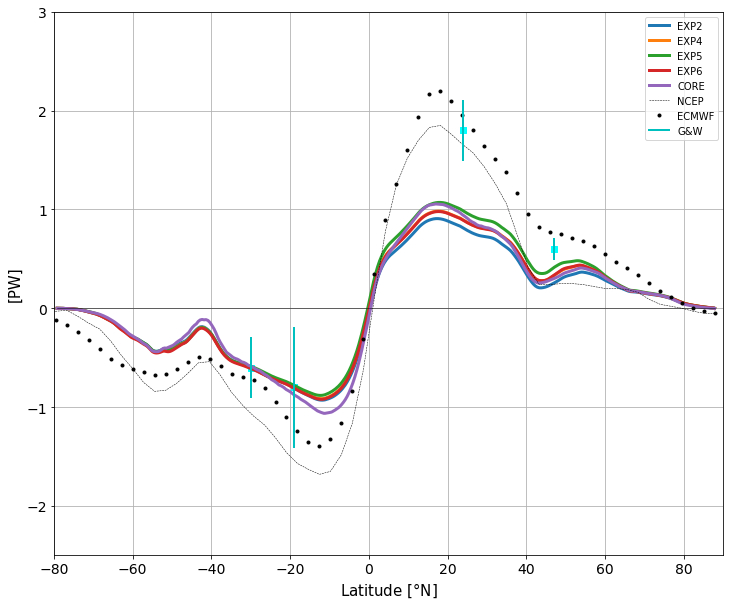

In [9]:
# Global Heat Transport
plt.figure(figsize=(12,10))
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_heat_transport.nc')
  adv, diff = get_adv_diff(ds);   HT = heatTrans(adv,diff); y = ds.yq;   plt.plot(y, HT, linewidth=3,label=labels[i]);     
plt.xlim(-80,90); plt.ylim(-2.5,3.0); plt.grid(True); plt.plot(y, y*0., 'k', linewidth=0.5); plt.plot(yobs,NCEP['Global'],'k--',linewidth=0.5,label='NCEP'); 
plt.plot(yobs,ECMWF['Global'],'k.',linewidth=0.5,label='ECMWF'); plotGandW(GandW['Global']['lat'],GandW['Global']['trans'],GandW['Global']['err']); plt.xlabel(r'Latitude [$\degree$N]',fontsize=15)
plt.ylabel('[PW]',fontsize=15); plt.legend(loc=0,fontsize=10)

### 1.4 Meridional Overturning Circulation

<center> <font size="4">Global</font>
 </center>
<table><tr><td><img   src='g.c2b6.GJRA.TL319_t061.long_JRA_mct.002_MOC_global.png'></td>
             <td><img src='g.c2b6.GJRA.TL319_t061.long_JRA_mct.004_MOC_global.png'></td></tr><tr>
             <td><img src='g.c2b6.GJRA.TL319_t061.long_JRA_mct.005_MOC_global.png'></td>
             <td><img src='g.c2b6.GJRA.TL319_t061.long_JRA_mct.006_MOC_global.png'></td></tr>
    <tr><td><img src='g.c2b6.GIAF.T62_t061.long_run.001_MOC_global.png'></td></tr>
</table>

<center> <font size="4">Atlantic</font></center>
<table><tr><td><img src='g.c2b6.GJRA.TL319_t061.long_JRA_mct.002_MOC_Atlantic.png'></td>
             <td><img src='g.c2b6.GJRA.TL319_t061.long_JRA_mct.004_MOC_Atlantic.png'></td></tr><tr>
             <td><img src='g.c2b6.GJRA.TL319_t061.long_JRA_mct.005_MOC_Atlantic.png'></td>
             <td><img src='g.c2b6.GJRA.TL319_t061.long_JRA_mct.006_MOC_Atlantic.png'></td></tr>
<tr><td><img src='g.c2b6.GIAF.T62_t061.long_run.001_MOC_Atlantic.png'></td></tr></table>

<center> <font size="4">AMOC time series @ 26N</font>

Text(0.5, 1.0, 'AMOC time series @ 26N')

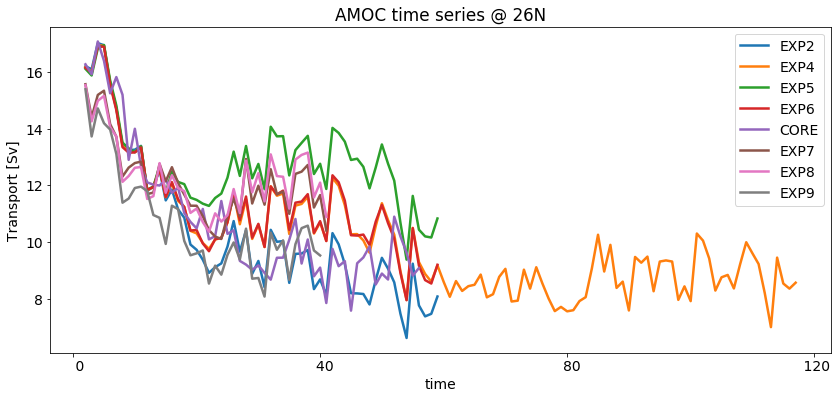

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MOC_26N_time_series.nc')
  #ds['time'] = ds.time - ds.time[0]
  ds.__xarray_dataarray_variable__.plot(ax=ax, label=labels[i], lw=2.5)
ax.set_ylabel('Transport [Sv]'); ax.legend(); ax.set_title('AMOC time series @ 26N')

<center> <font size="4">AMOC time series @ 45N</font>

Text(0.5, 1.0, 'AMOC time series @ 45N')

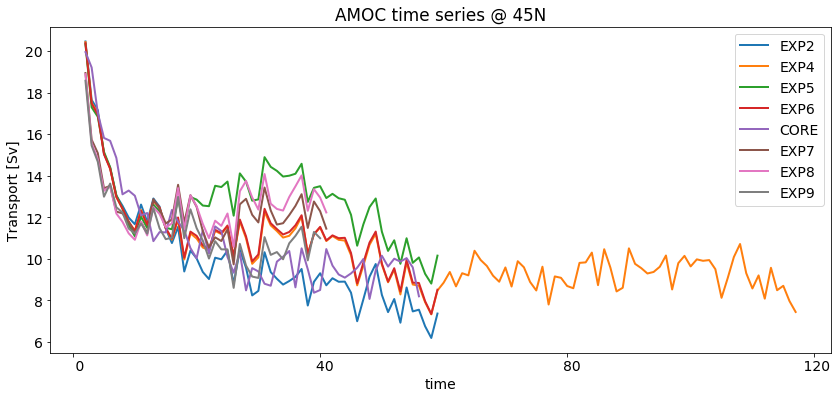

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MOC_45N_time_series.nc')
  #print(ds.time)
  #ds['time'] = ds.time - ds.time[0]
  ds.__xarray_dataarray_variable__.plot(ax=ax, label=labels[i], lw=2)
ax.set_ylabel('Transport [Sv]'); ax.legend(); ax.set_title('AMOC time series @ 45N')

### 1.5 Transports

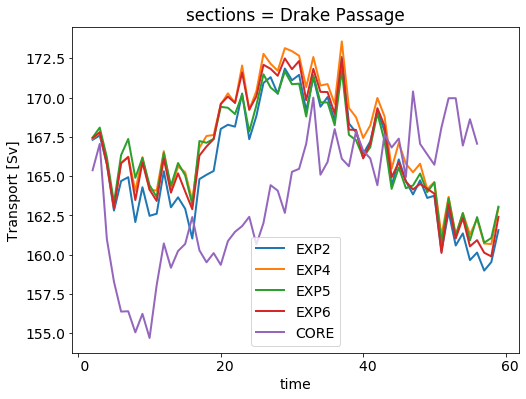

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_section_transports.nc')
  ds.transport.sel(sections='Drake Passage').plot(ax=ax, label=labels[i], lw=2)
ax.set_ylabel('Transport [Sv]'); ax.legend()

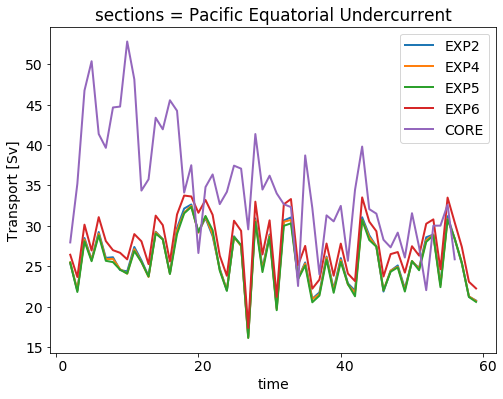

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_section_transports.nc')
  ds.transport.sel(sections='Pacific Equatorial Undercurrent').plot(ax=ax, label=labels[i], lw=2)
ax.set_ylabel('Transport [Sv]'); ax.legend()

### 1.6 Sea Ice

http://webext.cgd.ucar.edu/MOM/

## 2 Fully-coupled experiments

* bmom.e20.BMOM.f09_t061.long_run_mct.005 (Baseline)

* bmom.e20.BMOM.f09_t061.long_run_mct.006 (Hybrid)

* bmom.e20.BMOM.f09_t061.long_run_mct.007 (LBD and discontineous neutral diffusion)

* bmom.e20.BMOM.f09_t061.long_run_mct.008 (GME + MEKE)


In [29]:
path = '/glade/scratch/gmarques/'
exps = ['bmom.e20.BMOM.f09_t061.long_run_mct.005', \
        'bmom.e20.BMOM.f09_t061.long_run_mct.006',  \
        'bmom.e20.BMOM.f09_t061.long_run_mct.007',  \
        'bmom.e20.BMOM.f09_t061.long_run_mct.008']
labels = ['EXP5', 'EXP6', 'EXP7', 'EXP8']

### 2.1 Mixed layer depth (March Mean)

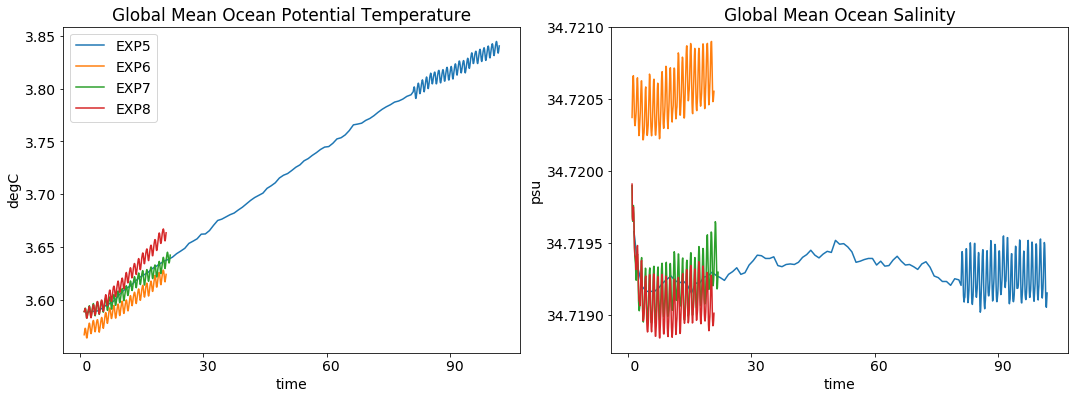

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
for i in range(len(exps)):
  ds = get_data(path+exps[i]+'/run/*mom6.hm_*.nc',variables)
  ds['thetaoga'].plot(ax=ax[0], label=labels[i])
  ds['soga'].plot(ax=ax[1])

ax[0].set_title(ds.thetaoga.attrs['long_name']); ax[0].set_ylabel(ds.thetaoga.attrs['units'])
ax[1].set_title(ds.soga.attrs['long_name']); ax[1].set_ylabel(ds.soga.attrs['units']); ax[0].legend()

### 2.2 Mixed layer depth (March Mean)

<table>
<tr><td><img src='bmom.e20.BMOM.f09_t061.long_run_mct.005_MLD_model_March.png'></td>
<td><img src='bmom.e20.BMOM.f09_t061.long_run_mct.006_MLD_model_March.png'></td></tr>
<tr><td><img src='bmom.e20.BMOM.f09_t061.long_run_mct.007_MLD_model_March.png'></td>
<td><img src='bmom.e20.BMOM.f09_t061.long_run_mct.008_MLD_model_March.png'></td></tr>    
</table>

### 2.3 MOC

<center> <font size="4">Global MOC</font>
 </center>
<table><tr><td><img   src='bmom.e20.BMOM.f09_t061.long_run_mct.005_MOC_global.png'></td>
             <td><img src='bmom.e20.BMOM.f09_t061.long_run_mct.006_MOC_global.png'></td></tr><tr>
             <td><img src='bmom.e20.BMOM.f09_t061.long_run_mct.007_MOC_global.png'></td>
             <td><img src='bmom.e20.BMOM.f09_t061.long_run_mct.008_MOC_global.png'></td></tr></table>

<center> <font size="4">Atlantic MOC</font>
 </center>
<table><tr><td><img   src='bmom.e20.BMOM.f09_t061.long_run_mct.005_MOC_Atlantic.png'></td>
             <td><img src='bmom.e20.BMOM.f09_t061.long_run_mct.006_MOC_Atlantic.png'></td></tr><tr>
             <td><img src='bmom.e20.BMOM.f09_t061.long_run_mct.007_MOC_Atlantic.png'></td>
             <td><img src='bmom.e20.BMOM.f09_t061.long_run_mct.008_MOC_Atlantic.png'></td></tr></table>

### MOC time series

Text(0.5, 1.0, 'AMOC time series @ 26N')

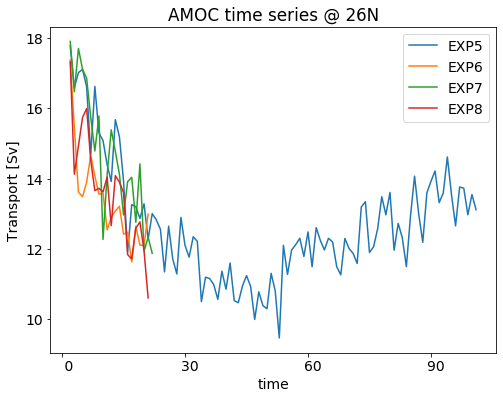

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MOC_26N_time_series.nc')
  ds.__xarray_dataarray_variable__.plot(ax=ax, label=labels[i])
ax.set_ylabel('Transport [Sv]'); ax.legend(); ax.set_title('AMOC time series @ 26N')

Text(0.5, 1.0, 'AMOC time series @ 45N')

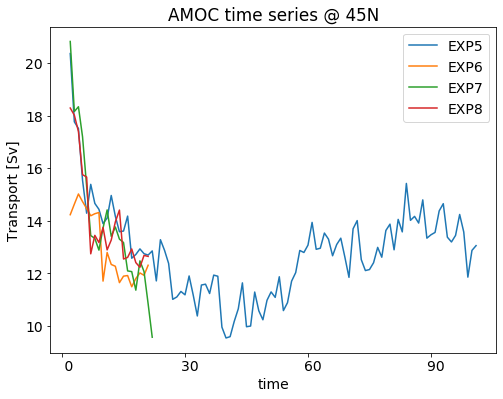

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MOC_45N_time_series.nc')
  ds.__xarray_dataarray_variable__.plot(ax=ax, label=labels[i])
ax.set_ylabel('Transport [Sv]'); ax.legend(); ax.set_title('AMOC time series @ 45N')